### Mixed foraging and compartment model

broadly
- do equids as trial
    - range of equid body masses, fitness, prop grass

To do
- loop over strategies (done)
- loop over configurations (done)
- loop over body size (done)
- loop over environmental change
    - between species and strats
- store:
    - time survived (done)
    - compartment stats (done)
    - track proportions of grass/browse in compartments
- implement traits
    - equids
        - velocity (done)
        - metabolism (done)
        - handling times
        - digestive times
    - grass/browse
- review g vs kg

Problems
- (fixed) code doesn't terminate if fat hits fatmax 
- (fixed) only 4 successes, even over 9000s
- (fixed)fat keeps accumulating even with those 4 successes
- (fixed)time and starvation death slightly out of sync. fix in "update compartments" 
- (fixed) lol resource distribution input is gabage
- some very large time outputs are produced. why?
    - distance to next res maxed out around 4 over 100,000,000 draws
    - looks like product of very low mean draws for disance and relationship to variance, might need very low variance for these cases to not have time blow up

Notes
- might be able to speed up by not regenerating distributions 


In [37]:
using Distributed
using DataFrames
using RCall
@everywhere using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra

include("./resource_functions.jl") # functions for the resource landscape
include("./consumer_functions.jl") # functions for the consumer dynamics
include("./intake_model_functions.jl") # functions for the consumer dynamics

    

┌ Info: Recompiling stale cache file /home/taran/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1184


find_nearest_resource (generic function with 2 methods)

In [23]:
using Random
Random.seed!(42);

In [24]:
number_resources = 2;
target_values = [0.0, 0.25, 0.5, 0.75, 1.0]; 
strategy_id = repeat(collect(1:number_resources), inner=(length(target_values), 1));
target_weight = repeat(target_values, outer=(number_resources, 1));
strategy_info = Tuple([strategy_id, target_weight]);


In [25]:
configurations = 20;

t = 0;   #[s]
t_max = 100000; # 2629800s in a month

species_list = [10.0, 100.0, 1000.0, 10000.0, 100000.0];
number_species = length(species_list);

#mouth = 0;
#mouth_max = 10;   #[g]

#gut = 11;
#gut_fill_max = 1000;  #[g]





#fat = 10;
#fat_max = 100000;   #[g]

#velocity = 1.0;   #[m/s]

at_food = false;
cropping = false;
chewing = false;

alpha = [1.0, 1.5]; # [g/s]
beta = 1.0;         # [g/s]
gamma = 0.01;        # [g/s]
rates = [alpha, beta, gamma];

#basal = 0.001      #[kj/s]
#field = 0.01;     #[kj/s]

num_succ = 0;


# first pass RLB plant data suggested 0.1-0.3 kgC/m2yr
# experiment with monthly productivity as mean 8.3-25 g/m2month
resource_gain = [16.7, 16.7]
#resource_stats =  [[2.0 3.0]; [2.0 10.0]]; # [[resource means]; [variances]]

2-element Array{Float64,1}:
 16.7
 16.7

In [26]:
# grass, browse
# justify pure forest and pure grassland distrib
resource_scenarios = [[[0.1 25.0]; [0.2 30.0]],
                     [[8.0 17.0]; [10.0 20.0]],
                     [[17.0 8.0]; [20.0 10.0]],
                     [[25.0 0.1]; [30.0 0.2]]];

[0.1, 8.0, 17.0, 25.0]

In [27]:
len = 1000000
check_array = zeros(Float64, len)
for i in 1:len
    blep, distance = forage(1, 0.5, 1, [[0.1 25.0]; [0.2 30.0]])
    #velocity = find_velocity(species_list[species]);
    #travel_time = distance/velocity;
    check_array[i]=distance
    end

In [30]:
# scenarios, data, species
species_data = zeros(Float64, 4, 6, length(strategy_id), number_species)

# loop through body masses
for species in 1:number_species
    strat_data = zeros(Float64, length(strategy_id), 6); # init array for storing data by config

    mouth_max = bite_size_allo(species_list[species], "graze"); # [g]
    gut_fill_max = gut_volume_g(species_list[species], "rumen foregut")
    velocity = find_velocity(species_list[species]);
    initial_energy_state, basal, field, fat_max = find_metabolism(species_list[species]);
    costs = [basal, field];
    
    
for scenario in 1:length(resource_scenarios)
    resource_stats = resource_scenarios[scenario]
    
    
    
# loop through strategies
for target in 1:length(strategy_id)
    
config_data = zeros(Float64, configurations, 6); # init array for storing data by config

# loop through configurations
for config = 1:configurations  # loop from 1:10

#target=1;
t=0;
num_succ = [0,0];
at_food = false;
cropping = false;
chewing = false;

mouth = 0;  #[g]
gut = 100;   #[g]
fat = initial_energy_state;   #[g]
        
chosen_resource = 0;

###
#1 while there is time left in the day
while t <= t_max #&& fat >= 0
    
    ### ###
    #2 if you're hungry
    #if gut <= gut_fill_max && fat <= fat_max  
        
        # if you're not at some food
        if at_food == false;
            # selects a resource to go after
            chosen_resource, distance = forage(strategy_id, target_weight, target, 
                resource_stats);
            travel_time = distance/velocity; 
            # move to the food
            mouth, gut, fat = update_compartments(travel_time, mouth, gut,
                fat, rates,costs, resource_gain; travelling=true)
            t += travel_time;
            at_food = true;
                    
                if fat <= 0
                    break
                end
                    
        end
        
        ### ### ###
        #3 if mouth isn't full and you're not chewing and you're at some food
        if mouth < mouth_max &&  chewing == false && at_food == true  # crop some food
                    
            mouth, gut, fat = update_compartments((1/alpha[chosen_resource]), 
                mouth, gut, fat, rates,costs, resource_gain; cropping=true, resource=chosen_resource)
            
            num_succ[chosen_resource] += 1
            t += (1/alpha[chosen_resource])
            at_food = false;
                    
                    if fat <= 0
                    break
                end
                    
        end
        
        # if you're mouth is full but not chewing
        if mouth >= mouth_max && chewing == false 
                    
                mouth = mouth_max;
                chewing = true # start chewing
        end
        
        
        if chewing == true && mouth > beta # if you are currently chewing   
            mouth, gut, fat = update_compartments((1/beta), mouth, 
                gut, fat, rates,costs, resource_gain; chewing=true)
            t += (1/beta);
                    
                if fat <= 0
                    break
                end
                    
        end
        if chewing == true && mouth <= beta
                chewing = false
            
            end #3 end of if mouth isn't full and you're not chewing
        ### ### ###
                        
        #end #2 end of if you're not hungry
        ### ###    
        
                    
        # add note on why this was necessary
        mouth, gut, fat = update_compartments(1, mouth, 
                gut, fat, rates,costs, resource_gain)
        
        if fat <= 0
                    break
                end
                
        t += 1.0;
            
    end  #1 end bout (while t<tmax_bout )
    ###
        
        
    config_data[config,1] = t;
    config_data[config,2] = num_succ[1];
    config_data[config,3] = num_succ[2];
    config_data[config,4] = mouth;
    config_data[config,5] = gut;
    config_data[config,6] = fat;
    
    end
# end loop through body configs
    #strat_data[target, 1] = mean(config_data)
    strat_data[target,1] = mean(config_data[:,1])
    strat_data[target,2] = mean(config_data[:,2])
    strat_data[target,3] = mean(config_data[:,3])
    strat_data[target,4] = mean(config_data[:,4])
    strat_data[target,5] = mean(config_data[:,5])
    strat_data[target,6] = mean(config_data[:,6])

    species_data[scenario,1,target, species] = strat_data[target,1]
    species_data[scenario,2,target, species] = strat_data[target,2]
    species_data[scenario,3,target, species] = strat_data[target,3]
    species_data[scenario,4,target, species] = strat_data[target,4]
    species_data[scenario,5,target, species] = strat_data[target,5]
    species_data[scenario,6,target, species] = strat_data[target,6]
            
    end # end loop through strategies
        
    
        
        
        end # end loop through resource scenarios

   
    

    end #loop through masses
# if [row, colum]

# time, graze, browse, mouth, gut, fat

In [31]:
# scenarios, data, strategies, species
species_data;

In [32]:
plotting_data = zeros(Float64, 4, 2, number_species); 

for scene in 1:4
    for datum in 1:2
        for species in 1:number_species
            
            plotting_data[scene,datum,species]=mean(species_data[scene,datum+1,:,species])
            
        end
    end
end

In [34]:
# restructure the data for basic plotting
# categorical heatmap with x=scenarios, y=equid_spp, color being proportion graze in diet
# (done) need to collapse the strategies 
# make Julia dataframe
# convert to R dataframe
# visualize in heatmap

df1 = convert(DataFrame, plotting_data[:,:,1]);
df2 = convert(DataFrame, plotting_data[:,:,2]);
df3 = convert(DataFrame, plotting_data[:,:,3]);
df4 = convert(DataFrame, plotting_data[:,:,4]);
df5 = convert(DataFrame, plotting_data[:,:,5]);

insert!(df1, 3, ["10kg","10kg","10kg","10kg",], :Species);
insert!(df2, 3, ["100kg","100kg","100kg","100kg",], :Species);
insert!(df3, 3, ["1000kg","1000kg","1000kg","1000kg",], :Species);
insert!(df4, 3, ["10000kg","10000kg","10000kg","10000kg",], :Species);
insert!(df5, 3, ["100000kg","100000kg","100000kg","100000kg",], :Species);

insert!(df1, 4, ["forest","shrubland","savanna","grassland",], :Scenario);
insert!(df2, 4, ["forest","shrubland","savanna","grassland",], :Scenario);
insert!(df3, 4, ["forest","shrubland","savanna","grassland",], :Scenario);
insert!(df4, 4, ["forest","shrubland","savanna","grassland",], :Scenario);
insert!(df5, 4, ["forest","shrubland","savanna","grassland",], :Scenario);



append!(df1,df2);
append!(df3, df4);
append!(df1, df3);
append!(df1, df5);

┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[34]:13
└ @ Core In[34]:13
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[34]:15
└ @ Core In[34]:15
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[34]:16
└ @ Core In[34]:16
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[34]:17
└ @ Core In[34]:17
┌ Warning: `

In [35]:
df = copy(df1);


In [ ]:
forest = df[[1,5,9,13,17], :]
shrubland= df[[2,6,10,14,18],:];
savanna= df[[3,7,11,15,19],:];
grassland=df[[4,8,12,16,20],:];

In [68]:
forest_graze = forest[:,1];
shrubland_graze = shrubland[:,1];
savanna_graze = savanna[:,1];
grassland_graze = grassland[:,1];

In [111]:
matrix = zeros(Float64, number_species, 4);
matrix[:,1] = forest_graze;
matrix[:,2] = shrubland_graze;
matrix[:,3] = savanna_graze;
matrix[:,4] = grassland_graze;

In [106]:
matrix

5×4 Array{Float64,2}:
  0.185     0.435      0.59      0.72
  0.175     0.48       0.59      0.76
 35.81   7780.14   13036.8   14187.5 
 29.58   7551.89   12229.0   13155.2 
 27.7    7977.81   12567.7   13551.5 

In [113]:
matrix[1,:]

4-element Array{Float64,1}:
 0.185              
 0.43500000000000005
 0.59               
 0.72               

In [121]:
#namepath = 
#xvec=;
#yvec=;
m=matrix;


LoadError: syntax: unexpected ";"

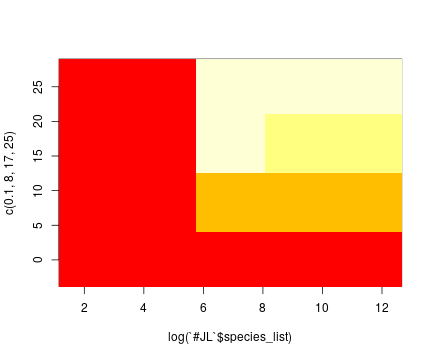

RObject{NilSxp}
NULL


In [149]:
R"""
body_sizes <- c("10kg", "100kg", "1000kg", "10000kg", "100000kg")
scenarios <- c("forest", "shrubland", "savanna", "grassland")
library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")
#image(z=($m))
#heatmap($m, scale="row", labRow=paste(body_sizes,sep=""), labCol=paste(scenarios,sep=""))
image(x=log($(species_list)), y=c(0.1, 8.0, 17.0, 25.0), z=$(m))
"""

In [36]:
df

,x1,x2,Species,Scenario
,Float64,Float64,String,String
1,0.185,0.735,10kg,forest
2,0.435,0.565,10kg,shrubland
3,0.59,0.41,10kg,savanna
4,0.72,0.21,10kg,grassland
5,0.175,0.75,100kg,forest
6,0.48,0.52,100kg,shrubland
7,0.59,0.41,100kg,savanna
8,0.76,0.15,100kg,grassland
9,35.81,15407.5,1000kg,forest


using Gadfly, RDatasets

Gadfly.plot(df, x="Scenario", y="Species", Geom.histogram2d)

Gadfly.plot(dataset("car", "Womenlf"), x="HIncome", y="Region", Geom.histogram2d)